In [7]:
%pip install -Uq pymcel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
%pip install -Uq rebound

Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for rebound (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [57 lines of output]
      C:\Users\juane\AppData\Local\Temp\pip-build-env-47u76don\overlay\Lib\site-packages\setuptools\_distutils\dist.py:287: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      C:\Users\juane\AppData\Local\Temp\pip-build-env-47u76don\overlay\Lib\site-packages\setuptools\_distutils\dist.py:287: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\juane\AppData\Local\Temp\pip-build-env-47u76don\overlay\Lib\site-packages\setuptools\dist.py:765: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License :: 

In [9]:
%pip install -Uq pandas plotly nbformat 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pymcel as pc

Bienvenido a PyMCel v0.9.10 ¡al infinito y más allá!


In [7]:
tabla, jd, X_Sol = pc.consulta_horizons(
    id='Sun',
    location='@SSB',
    epochs='2026-02-26 00:00:00',
)

In [18]:
X_Sol

array([-3.99267884e+08, -8.24090450e+08,  1.85429947e+07,  1.22108229e+01,
        1.23932702e+00, -2.42604119e-01])

In [17]:
tabla_jupiter, jd_jupiter, X_jupiter = pc.consulta_horizons(
    id='jupiter barycenter',
    location='@SSB',
    epochs='2026-02-26 00:00:00',
)
X_jupiter

array([-3.13499559e+11,  7.16531655e+11,  4.04379637e+09, -1.21253772e+04,
       -4.61863891e+03,  2.90510926e+02])

In [19]:
r_sol_0 = X_Sol[:3]
v_sol_0 = X_Sol[3:] 
r_jup_0 = X_jupiter[:3]
v_jup_0 = X_jupiter[3:]


In [20]:
deltat = 1 * 86400  # 1 día en segundos
r_jup_dt=r_jup_0 + v_jup_0 * deltat
r_sol_dt=r_sol_0 + v_sol_0 * deltat

r_jup_dt, r_sol_dt

(array([-3.14547192e+11,  7.16132604e+11,  4.06889651e+09]),
 array([-3.98212869e+08, -8.23983372e+08,  1.85220337e+07]))

In [22]:
mu_sol = pc.constantes.mu_sun
mu_jup = pc.constantes.mu_jupiter
rij_vec = r_jup_0 - r_sol_0
v_jup_dt = v_jup_0 - mu_sol * rij_vec / np.linalg.norm(rij_vec)**3 * deltat
v_sol_dt = v_sol_0 + mu_jup * rij_vec / np.linalg.norm(rij_vec)**3 * deltat
v_jup_dt, v_sol_dt


(array([-12117.89040582,  -4635.79206931,    290.41467508]),
 array([12.2036746 ,  1.25570472, -0.24251222]))

[]


[]


AttributeError: module 'pymcel' has no attribute 'sun_posvel'

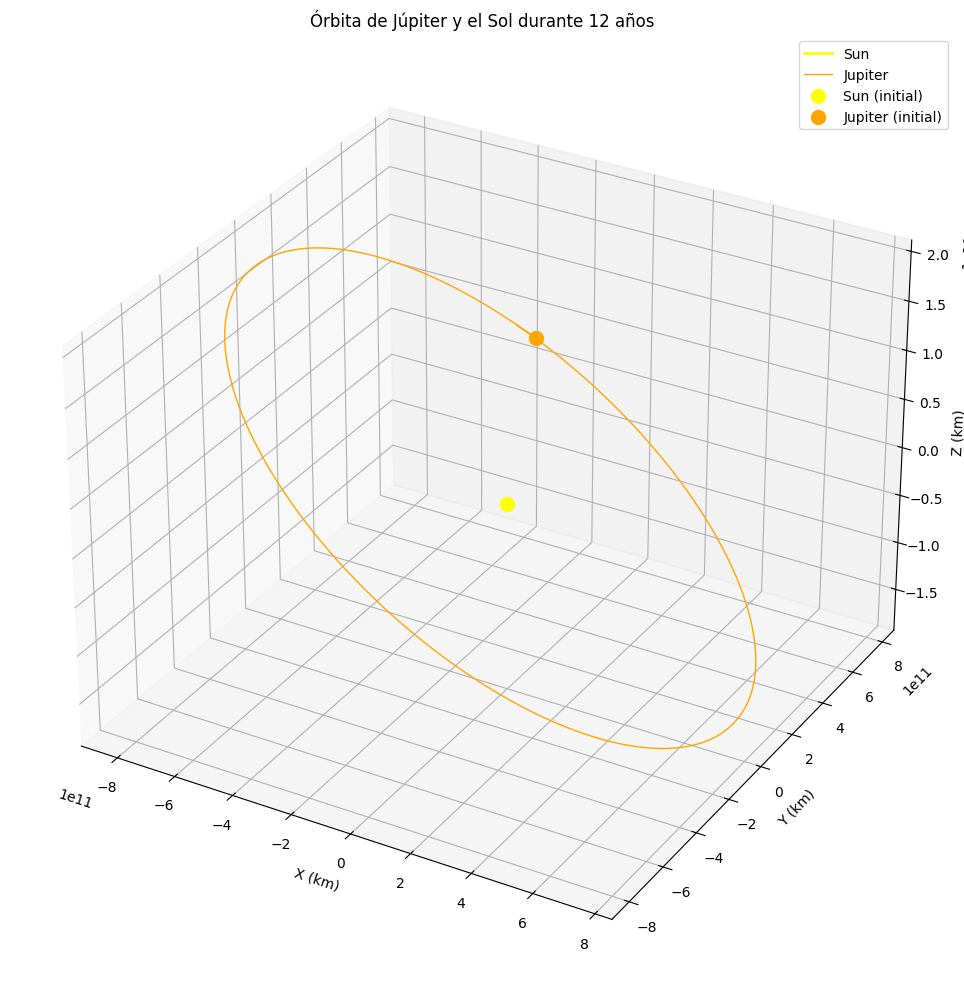

In [23]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Initialize arrays to store positions
years = 12
days_per_year = 365.25
total_days = int(years * days_per_year)
deltat = 1 * 86400  # 1 día en segundos

# Storage for trajectories
r_jup_trajectory = [r_jup_0.copy()]
r_sol_trajectory = [r_sol_0.copy()]

# Current state
r_jup = r_jup_0.copy()
v_jup = v_jup_0.copy()
r_sol = r_sol_0.copy()
v_sol = v_sol_0.copy()

# Iterative integration
for i in range(total_days):
    rij_vec = r_jup - r_sol
    rij_norm = np.linalg.norm(rij_vec)
    
    # Update velocities
    v_jup = v_jup - mu_sol * rij_vec / rij_norm**3 * deltat
    v_sol = v_sol + mu_jup * rij_vec / rij_norm**3 * deltat
    
    # Update positions
    r_jup = r_jup + v_jup * deltat
    r_sol = r_sol + v_sol * deltat
    
    # Store positions
    r_jup_trajectory.append(r_jup.copy())
    r_sol_trajectory.append(r_sol.copy())

# Convert to numpy arrays
r_jup_trajectory = np.array(r_jup_trajectory)
r_sol_trajectory = np.array(r_sol_trajectory)

# 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(r_sol_trajectory[:, 0], r_sol_trajectory[:, 1], r_sol_trajectory[:, 2], 
        label='Sun', color='yellow', linewidth=2)
ax.plot(r_jup_trajectory[:, 0], r_jup_trajectory[:, 1], r_jup_trajectory[:, 2], 
        label='Jupiter', color='orange', linewidth=1)

ax.scatter(*r_sol_trajectory[0], color='yellow', s=100, marker='o', label='Sun (initial)')
ax.scatter(*r_jup_trajectory[0], color='orange', s=100, marker='o', label='Jupiter (initial)')

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title(f'Órbita de Júpiter y el Sol durante {years} años')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

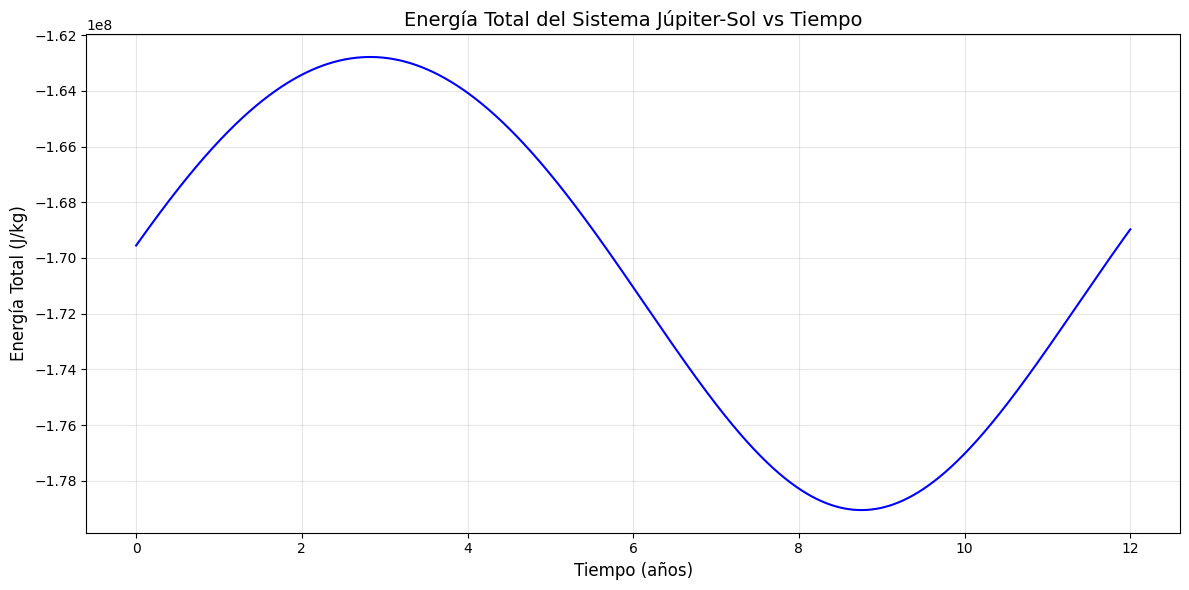

In [24]:
# Calculate total energy as a function of time
energy_trajectory = []

for i in range(len(r_jup_trajectory)):
    r_jup_pos = r_jup_trajectory[i]
    r_sol_pos = r_sol_trajectory[i]
    
    # Kinetic energy (we need to reconstruct velocities or use a simplified approach)
    # For this, we'll calculate the potential energy and use energy conservation
    rij = r_jup_pos - r_sol_pos
    rij_distance = np.linalg.norm(rij)
    
    # Potential energy of the system
    U = -mu_sol * 1 / rij_distance  # Simplified: treating Sun as stationary
    
    energy_trajectory.append(U)

energy_trajectory = np.array(energy_trajectory)

# Plot energy vs time
time_days = np.arange(len(energy_trajectory))
time_years = time_days / 365.25

plt.figure(figsize=(12, 6))
plt.plot(time_years, energy_trajectory, linewidth=1.5, color='blue')
plt.xlabel('Tiempo (años)', fontsize=12)
plt.ylabel('Energía Total (J/kg)', fontsize=12)
plt.title('Energía Total del Sistema Júpiter-Sol vs Tiempo', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()